In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit
from scipy.stats import linregress
import scipy.stats as stats
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


import warnings
warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
    
    
def pull_surveillance_data():
    #flu surveillance data
    mapping = {'death':'Deaths', 'case':'Cases', 'hospitalization': 'Hospitalizations'}
    
    url = f"https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/main/target-data/target-hospital-admissions.csv"
    return pd.read_csv(url, dtype={'location':str})



def pull_flu_scenario_modeling_hub_predictions(model,dates):
    """pull_scenario_modeling_hub_predictions. Load predictions of the model saved by the scenario modeling
    hub.

    Parameters
    ----------
    model : str
        Model name on thhe
    dates : list or string
        List of potential dates in the iso format, e.g., 'yyyy-mm-dd', for the submission.
    """
    predictions = None
    if isinstance(dates,str):
        dates = [dates]
    for date in dates:
        url = f"https://raw.githubusercontent.com/midas-network/flu-scenario-modeling-hub/master/data-processed/{model}/{date}-{model}"
        for ext in [".gz.parquet", ".parquet"]:
                try:
                    predictions = pd.read_parquet(url+ext)
                    
                except:
                    pass

    if predictions is None:
        print(f"Data for model {model} and date {dates} unavailable")
    return predictions

def format_observations(location, start_week = pd.to_datetime('2023-09-09') ):
    observations = pd.read_parquet(f"../fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    max_date = pd.to_datetime(observations.date.max())
    observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

    #filter location
    observations = observations[observations['location'] == location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    return observations

In [4]:
target = 'hospitalization'
incidence=True
observations = pull_surveillance_data()
observations


,Unnamed: 0,date,location,location_name,value,weekly_rate
0,1,2024-04-27,02,Alaska,3,0.421688
1,2,2024-04-27,01,Alabama,16,0.315970
2,3,2024-04-27,05,Arkansas,30,0.986233
3,4,2024-04-27,04,Arizona,106,1.443941
4,5,2024-04-27,06,California,151,0.388309
...,...,...,...,...,...,...
6143,6144,2022-02-12,50,Vermont,0,0.000000
6144,6145,2022-02-12,53,Washington,8,0.103415
6145,6146,2022-02-12,55,Wisconsin,29,0.492275
6146,6147,2022-02-12,54,West Virginia,5,0.281694


In [6]:
models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
          'MOBS_NEU-GLEAM_FLU', 'NIH-FluD', 'NIH-Flu_TS', 'NotreDame-FRED', 'PSI-M2', 'USC-SIkJalpha',
          'UT-ImmunoSEIRS', 'UVA-FluXSim']
dates = '2023-09-03'
rd = 4


predictionsall = pd.DataFrame()
for model in models:
    df = pd.read_parquet(f'../fludat/{model}_rd4.pq')
    print(model, len(df.location.unique())) 
    
    predictionsall = pd.concat([predictionsall, df])

CADPH-FluCAT 1
CDDEP-FluCompModel 1
Ensemble 57
Ensemble_LOP 57
Ensemble_LOP_untrimmed 57
MOBS_NEU-GLEAM_FLU 52
NIH-FluD 1
NIH-Flu_TS 13
NotreDame-FRED 52
PSI-M2 52
USC-SIkJalpha 57
UT-ImmunoSEIRS 51
UVA-FluXSim 1


In [7]:
singleloc_models = ['CADPH-FluCAT', 'CDDEP-FluCompModel', 'NIH-FluD', 'UVA-FluXSim']

predictionsall = predictionsall[~predictionsall['Model'].isin(singleloc_models)]

# filter by trajectories and only look at age group with all ages combined
predictions_traj = predictionsall[(predictionsall.output_type == 'sample') & \
                                   (predictionsall.age_group == '0-130')]
# filter by dates with data
predictions_traj = predictions_traj[predictions_traj.target_end_date <= pd.to_datetime(observations.date.max())]

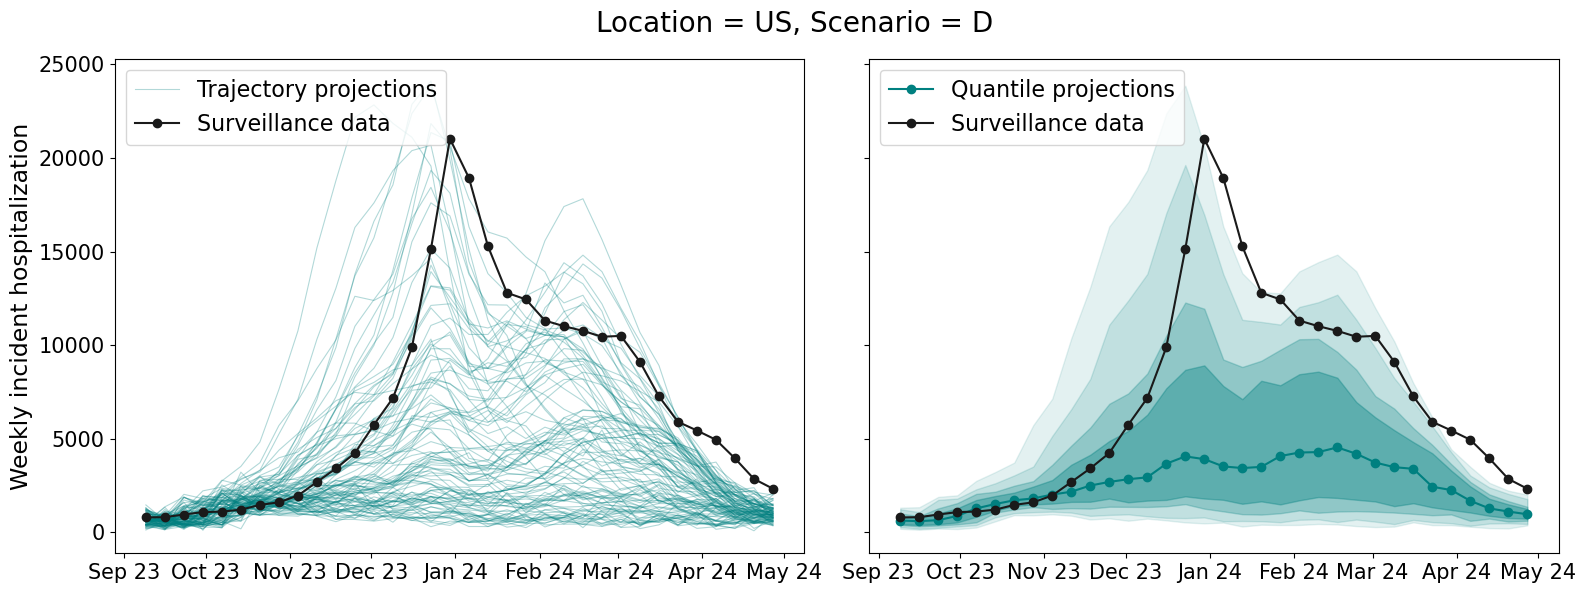

In [8]:
# plot trajectory and quantile format for scenario D for MOBS model in the US
model = 'MOBS_NEU-GLEAM_FLU'

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

   
    
# filter by dates with data
predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                (predictions_traj.Model == model)]   

fig, axes = plt.subplots(1,2, figsize=(16,6), sharey=True)


scenario = 'D'
location = 'US'
target = 'hosp'
incidence = True

map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1


if target == 'hosp':
    target_obs = 'hospitalization'
else:
    target_obs = target_obs
    

predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-08-14') & \
                              (predictions.location == location) & \
                              (predictions.target == 'inc ' + target)  & \
                              (predictions.target_end_date <= max_date) & \
                              (predictions.target_end_date >= start_week)]

plt.subplot(1,2,1)

for traj in predictionsfilt.output_type_id.unique():
    p = predictionsfilt[predictionsfilt.output_type_id == traj]
    plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8)
    
plt.plot(p.target_end_date,p['value'],
             '-', color='teal', alpha=.3,linewidth=.8, label=fr"Trajectory projections")


observations = format_observations(location=location)

axes[0].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(axes[0])

plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization", fontsize=17)
plt.legend(loc='upper left', fontsize=16)
axes[0].tick_params(axis='both', labelsize=15)


plt.subplot(1,2,2)

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(predictionsfilt.groupby('horizon')['value'].quantile(q[0]))
    qlow = list(predictionsfilt.groupby('horizon')['value'].quantile(q[1]))
    
    plt.fill_between(predictionsfilt.target_end_date.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(predictionsfilt.groupby('horizon')['value'].quantile(.5))

plt.plot(predictionsfilt.target_end_date.unique(),qmed,'-o', color='teal', alpha=1,
                               label=fr"Quantile projections")
    
observations = format_observations(location=location)

axes[1].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')
      
set_date_axis_fmt(axes[1])

axes[1].tick_params(axis='both', labelsize=15)

#set y axis 
#axes[1].set_ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalization")
    
plt.legend(loc='upper left', fontsize=16)

plt.suptitle(f'Location = {location}, Scenario = {scenario}', fontsize=20)

plt.tight_layout()

#plt.savefig('../trajectory_quantile_format.pdf')
plt.show()

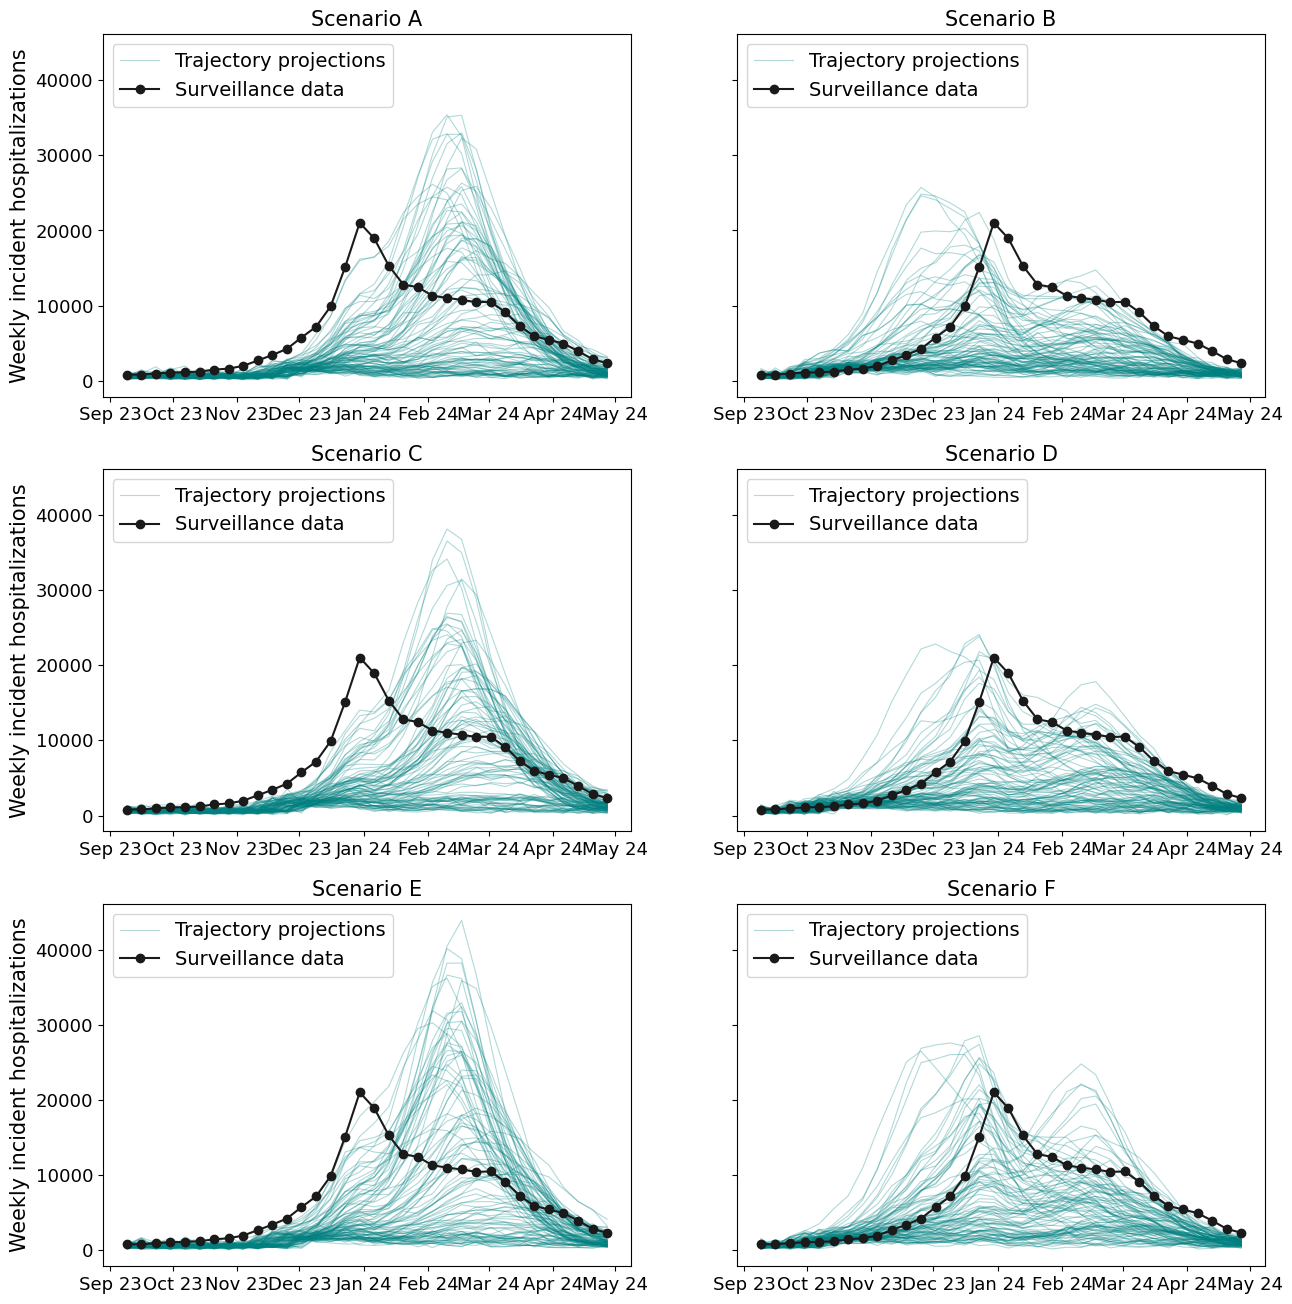

In [9]:
# plot trajectories for all SMH scenarios in US for MOBS model
model = 'MOBS_NEU-GLEAM_FLU'

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

   
    
# filter by dates with data
predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                (predictions_traj.Model == model)]   

fig, ax = plt.subplots(3,2, figsize=(15,16), sharey=True)


#scenario = 'F'
location = 'US'
target = 'hosp'
incidence = True

i=1
for scenario in ['A', 'B','C', 'D', 'E', 'F']:

    map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

    
    if i==1:
        a=0
        b=0
    elif i==2:
        a=0
        b=1
    elif i==3:
        a=1
        b=0
    elif i==4:
        a=1
        b=1
    elif i==5:
        a=2
        b=0
    elif i==6:
        a=2
        b=1

    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target_obs


    predictionsfilt = predictions[(predictions.scenario_id == scenario + '-2023-08-14') & \
                                  (predictions.location == location) & \
                                  (predictions.target == 'inc ' + target)  & \
                                  (predictions.target_end_date <= max_date) & \
                                  (predictions.target_end_date >= start_week)]

    plt.subplot(3,2,i)

    for traj in predictionsfilt.output_type_id.unique():
        p = predictionsfilt[predictionsfilt.output_type_id == traj]
        plt.plot(p.target_end_date,p['value'],
                 '-', color='teal', alpha=.3,linewidth=.8)

    plt.plot(p.target_end_date,p['value'],
                 '-', color='teal', alpha=.3,linewidth=.8, label=fr"Trajectory projections")


    observations = format_observations(location=location)

    ax[a][b].plot(observations.get_t(),observations.get_value(), '-o', color='#1a1a1a', label = 'Surveillance data')

    set_date_axis_fmt(ax[a][b])

    if i==1:
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalizations", fontsize=15)
        plt.title('Scenario A', fontsize=15)
    elif i==2:
        plt.title('Scenario B', fontsize=15)
    elif i==3:
        plt.title('Scenario C', fontsize=15)
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalizations", fontsize=15)
    elif i==4:
        plt.title('Scenario D', fontsize=15)
    elif i==5:
        plt.title('Scenario E', fontsize=15)
        plt.ylabel(f"Weekly {'incident' if incidence else 'cumulative'} hospitalizations", fontsize=15)
    elif i==6:
        plt.title('Scenario F', fontsize=15)
    plt.legend(loc='upper left', fontsize=14)
    ax[a][b].tick_params(axis='both', labelsize=13)
    
    
    
    i+=1

#plt.tight_layout()

#plt.savefig('../figs/trajectory_format_scenALL.pdf')
plt.show()

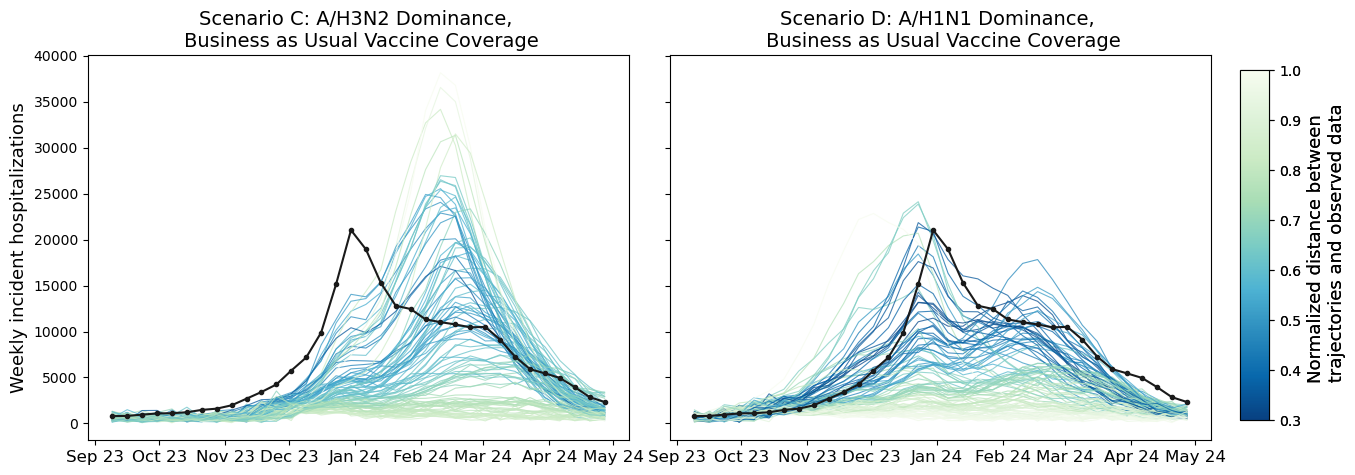

In [10]:
# plot trajectories for scenarios C and D, color trajectories by their distance to observation vector

fig, ax = plt.subplots(1,2,figsize=(14.5,5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.075, hspace=0.075)
model = 'MOBS_NEU-GLEAM_FLU'

observations['date'] = pd.to_datetime(observations['date'])
obs = observations[(observations.location=='US')&(observations.date<=predictions.target_end_date.max())&\
                   (observations.date >= predictions.target_end_date.min())].sort_values(by=['date'])
y = np.array(obs.value)

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())

z=1
for scenario in ['C', 'D']:
    
    
    # filter by dates with data
    predictions = predictions_traj[(predictions_traj.target_end_date <= max_date) & 
                                    (predictions_traj.Model == model) & (predictions_traj.location=='US') &\
                                    (predictions_traj.target == 'inc hosp') &\
                                    (predictions_traj.scenario_id==scenario+'-2023-08-14')].sort_values(by='target_end_date')   
    predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])


    preds_dist = pd.DataFrame()
    for i in predictions.output_type_id.unique():
        dist =0 
        df = predictions[predictions.output_type_id==i]
        
        Xi = np.array(predictions[predictions.output_type_id==i].value)
            
        df['calibration'] = np.sqrt(np.sum((Xi-y)**2))
        

        preds_dist = pd.concat([preds_dist, df])
        
    
    preds_dist['calib_color_value'] = preds_dist['calibration'] / preds_dist.calibration.max()

    # Create a colormap
    normcalib = plt.Normalize(.3, 1)
    cmap = cm.GnBu_r  # You can use other colormaps like 'plasma', 'inferno', etc.


    plt.subplot(1,2,z)
    for traj in preds_dist.output_type_id.unique():
            p = preds_dist[preds_dist.output_type_id == traj]
            sns.lineplot(x='target_end_date',y='value',data=p,
                      color=cmap(normcalib(p['calib_color_value']))[0], alpha=.75,linewidth=.8)

    ax[z-1].plot(obs['date'],obs['value'], '-o', color='#1a1a1a', label = 'Surveillance data', markersize=3)

    plt.xlabel('')
    plt.ylabel('Weekly incident hospitalizations', fontsize=13)

    if scenario =='C':
        plt.title('Scenario C: A/H3N2 Dominance, \n Business as Usual Vaccine Coverage', fontsize=14)
    else:
        plt.title('Scenario D: A/H1N1 Dominance, \n Business as Usual Vaccine Coverage', fontsize=14)
    
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=normcalib)
    #sm.set_array([])
    #if z==2:
     #   # Use `make_axes_locatable` to avoid shrinking
      #  divider = make_axes_locatable(ax[z-1])
       # cax = divider.append_axes("right", size="2%", pad=0.02)  # Create space for colorbar

        
        #plt.colorbar(sm,cax=cax, ).set_label(label='Normalized distance between trajectories \n and observed data',
         #                                    size=13)

    plt.xticks(fontsize=12)
    
    z+=1
    
    
    set_date_axis_fmt(ax[0])
    set_date_axis_fmt(ax[1])

    #plt.tight_layout()
    
    
    # Create an axis on the right side of the plot for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normcalib)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(sm, cax=cbar_ax).set_label(label='Normalized distance between \n trajectories and observed data',
                                            size=13)

    # Adjust layout so subplots and colorbar fit well without overlap
    plt.subplots_adjust(right=0.9)

#plt.tight_layout()
    
#plt.savefig('../figs/trajectory_distance_calibration_invert.pdf')